In [1]:
import xarray as xr 
import cartopy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cv2
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
import os 
from matplotlib.patches import Polygon, FancyArrowPatch    # 用于画箭头的 ， 虽然没用到
from shapely.geometry import Polygon as ShapelyPolygon     # 用于确定多边形中心点位置
# 防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# 连续区域识别 

## 找出需要的亮温区,并获取组件信息

In [2]:
# 找边界
def get_Component_Info(tb): 
    """
    tb: 亮温数据，  二维numpy数组
    return: 
        stats: (labels_id_number, 5)
        labels ： 2 dimension  array ，与原数据tb据形状一样
    注意：
        1.labels_id 的总数可以通过 len(stats) 获得
        2. ##真实的值
            mask = np.isin(num_labels, match_TbValue_IdList)
            tbdata = np.where([mask], tb, np.nan)[0]
          ## 拿出stats， 利用上方类似的两行带代码， 也可以通过循环
        3. 所有的坐标其实都是原来数据的索引  ， 比如stats中的x, y 
    """

    # 找出所有Tb < 225K的像素
    _, cold_cores = cv2.threshold(tb, 225, 255, cv2.THRESH_BINARY_INV)
    cold_cores = cold_cores.astype(np.uint8)   # # 转换为8位无符号整型以便后续处理
    
    # 找出所有Tb < 241K的像素
    _, cold_regions = cv2.threshold(tb, 241, 255, cv2.THRESH_BINARY_INV)
    cold_regions = cold_regions.astype(np.uint8)
    
    # # # 使用形态学膨胀操作扩展冷云区域、冷云核心，   也就是把边缘弄得精细一些。   
    # kernel = np.ones((3,3), np.uint8)  
    # cold_cores = cv2.dilate(cold_cores, kernel, iterations= 1)
    # cold_regions = cv2.dilate(cold_regions, kernel, iterations= 1)
    
    # 不同的组件识别获取 (对    冷云区   进行了一个一个的独立)
    num_labels_regions, labels_regions, stats_regions, centroids_regions = cv2.connectedComponentsWithStats(cold_regions,  connectivity=8)

    # 获取符合亮温的 label id 
    match_TbValue_IdList = []
    for region_id in range(1, num_labels_regions):  # 跳过背景 (0)                                        
        i_part_region_mask = (labels_regions == region_id).astype(np.uint8)   # np.uint8 将布尔值转化为0或 1 
        both_exist_mask = (i_part_region_mask == 1) & (cold_cores== 255)   # 既存在 冷区域，又存在冷核
        if np.any(both_exist_mask ):    
           match_TbValue_IdList.append(region_id)   # 两个都存在保留， 冷区域
    return labels_regions, stats_regions, match_TbValue_IdList

## 计算面积的函数

In [3]:
def get_RealAreaArray(tb, lat):
    """
    tb:  2 numpy array , 亮温数据
    lat: 从dataset中提取的经度
    :return 
        area_per_pixel_km2:  形状与tb对应
    """
     # 计算每个像素对应的真实面积（km²）      
    R = 6371             # 地球半径（km）
    dlon = 0.07          # Grid Sat B1 的分辨率 0.07度  * 0.07度
    dlat = 0.07
    dlon_rad = np.radians(dlon)  # 转换为弧度 , 弧度单位rad
    dlat_rad = np.radians(dlat)
    
    # 获取实际的面积, 单位km^2 
    area_per_pixel_km2 = np.zeros_like(tb, dtype=np.float32)
    for i in range(tb.shape[0]):  # 遍历每一行（纬度）
        lat_rad = np.radians(lat[i])  # 当前行的纬度（假设已知）
        area = (R ** 2) * dlon_rad * dlat_rad * np.cos(lat_rad)      # np.cos 需要弧度, 所以才转换的
        area_per_pixel_km2[i, :] = area
    return area_per_pixel_km2
    

In [4]:
# pix_area_array = get_RealAreaArray(tb_data_list[0], lat)

In [5]:
# print(pix_area_array.max())  # 单个像素最大60多 km2
# print(pix_area_array.min())  # 单个像素最小20多 km2

## 判断面积和离心率

In [6]:
def match_AreaAndEllipse(tb,lat, Component_Info):
    """
    tb: 2 np array 
    lat: 从dataset中提取的经度
    :return 
        real_areas_km2  :是一维数组， 对应每个组件的真实面积
        match_AreaAndEllipse_IdList： 满足面积 >4e4, 离心率小于0.4 的label_id list 
    """
    # 获取各组件面积
    area_per_pixel_km2 = get_RealAreaArray(tb, lat)
    labels, stats, match_Tb_IdLidt = Component_Info  # 获取组件对应的信息 
    
    # 基于通过亮温区域获取组件的label id ,来判断符合条件的面积的label id
    real_areas_km2 = []
    for label_id in match_Tb_IdLidt:  #  match_Tb_IdLidt从亮温区域获取的label_id
        mask = (labels == label_id)
        real_area = np.sum(area_per_pixel_km2[mask])
        real_areas_km2.append(real_area)           # real_areas_km2 是列表， 每个元素对应每个组件的真实面积
    real_areas_km2 = np.array(real_areas_km2)      # 由列表转化为数组
    # 判断条件===============>>> 面积和离心率
    criteria_1 = 4e4
    
    match_Tb_IdLidt_copy = np.array(match_Tb_IdLidt)
    # 1. 真实面积大于4e4
    area_greater_4e4_ids = match_Tb_IdLidt_copy[real_areas_km2 >  criteria_1] 
    # 2. 根据面积拿到一组 像素label id ， 接着计算离心率， 判断离心率大于0.4
    match_AreaAndEllipse_IdList = []

    for i_label in area_greater_4e4_ids:  # 肯定背景标签0, 因为是经过Tb挑选， 得出来的label id
        y_coords, x_coords = np.where(labels == i_label)
        coords = np.column_stack((x_coords, y_coords))
        ellipse = cv2.fitEllipse(coords)    # 椭圆拟合的点一定要大于5， 但是按照筛选的条件，一般肯定要大于5个点的
        # 计算离心率  
        ellipse_eccentricity = np.sqrt(1 - (ellipse[1][0] / ellipse[1][1]) ** 2)
        # 符合离心率条件的 i_label 
        if ellipse_eccentricity > 0.4:
            match_AreaAndEllipse_IdList.append(i_label)
    match_AreaAndEllipse_IdList = np.array(match_AreaAndEllipse_IdList)
    
    """ 至此， 对于Tb< 数值、面积大于4e4km^2 且离心率大于0.4的判断   都完成了
        对应label_id  ：  输出 match_AreaAndEllipse_IdList
    """
    return  match_AreaAndEllipse_IdList
 

## 像素点坐标 x, y, w, h 转化为经纬度真实信息

In [7]:
def  statsTransformLonLat(stats, lon, lat):
    """ 
    :param stats:  x,y, w, h
    :param lon: 
    :param lat: 
    :return: 
    """
    all_PointsList = []
    for i_boxesInFo in stats:
        x_min, y_top, width, height = i_boxesInFo[0:4]  # 拿出四个值  
        points = [
                (lon[x_min].item(), lat[y_top ].item()  ),   # 左上
                (lon[x_min + width -1].item() , lat[y_top ].item() ),   # 右上
                (lon[x_min + width-1].item() , lat[y_top + height -1 ].item()),   # 右下
                (lon[x_min].item(), lat[y_top + height -1 ].item())    # 左下
                 ]
        all_PointsList.append(points)
    return  all_PointsList

## 通过label_id ,获得对应框经纬度信息和框内真实数据

In [8]:
def get_dataBy_id(labels, stats, matched_LabelIdList ,tb ,lon,lat):
    """ 
    :param labels: 是一个二维数组， 形状与原始数据相同
    :matched_LabelIdList :  是一个一维数组， 也就是符合条件的id 
    :new_tb : 是二维数组， 得到真实的值
    """        
    # 获取干净的数据 
    mask = np.isin(labels,matched_LabelIdList)
    cleaned_tb = np.where( mask, tb,np.nan)

    # 获取框坐标 
    points_list = []   # 储存框经纬度
    current_boxes = []  # 储存x,y, w, h, area , label_id 
    for i_id in matched_LabelIdList:
        print("**************************")
        print("i_id",i_id)
        print("stats[i_id]:", stats[i_id])
        
        x_min, y_top, width, height, area = stats[i_id]
        # print("print(i_id)")
        # print(i_id)
        # print("matched_LabelIdList")
        # print(matched_LabelIdList)
        # print("===============================================")
        # print("print(x_min, y_top, width, height, area)")
        # print(x_min, y_top, width, height, area)
        # print("===============================================")
        # 注意 索引点加上  stats的 w 或者 h 的时候， 最终索引一定要  减一，  否则碰到边界的时候， 会越界。
        points = [
        (lon[x_min].item(), lat[y_top ].item()  ),   # 左上
        (lon[x_min + width -1].item() , lat[y_top ].item() ),   # 右上
        (lon[x_min + width-1].item() , lat[y_top + height -1 ].item()),   # 右下
        (lon[x_min].item(), lat[y_top + height -1 ].item())    # 左下
         ]
        print("id_finish")
        print("**************************")

        points_list.append((points, i_id))
        # current_boxes 每个元素都是stats元素的x, y, w, h, area, 以及 对应的 label_id
        current_boxes.append([x_min, y_top, width, height, area, i_id])
    # 变为numpy类型                                                 
    current_boxes = np.array(current_boxes)
    return cleaned_tb, points_list ,  current_boxes 


## 实现不同时刻覆盖的识别

In [9]:
def calculate_overlap_area(rect1, rect2):
    """ 
    计算两个矩形的重叠面积。
    :param rect1: 第一个矩形，格式为 (x, y, width, height)
    :param rect2: 第二个矩形，格式为 (x, y, width, height)
    :return: 重叠面积。如果没有重叠，则返回0。
    
    # # # 示例调用
    # rectA = (100, 150, 200, 100)  # 矩形A的坐标和尺寸
    # rectB = (150, 175, 100, 150)  # 矩形B的坐标和尺寸
    # 
    # overlap_area = calculate_overlap_area(rectA, rectB)
    # print("重叠面积:", overlap_area)   
    """
    # 解包矩形参数
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    area1 = w1 * h1
    area2 = w2 * h2

    # 计算x轴方向上的重叠
    left = max(x1, x2)
    right = min(x1 + w1, x2 + w2)
    overlap_x = max(0, right - left)

    # 计算y轴方向上的重叠
    top = max(y1, y2)
    bottom = min(y1 + h1, y2 + h2)
    overlap_y = max(0, bottom - top)
    overlap_area = overlap_x * overlap_y
    ration1 = overlap_area/area1
    ration2 = overlap_area/area2
    return max(ration1, ration2)


## 合并两个框

In [10]:
def merge_boxes(box1, box2):
    """
    合并两个矩形为一个最小的外接矩形。
    :param box1: (x, y, w, h)
    :param box2: (x, y, w, h)
    :return: merged_box (x, y, w, h)
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    new_x = min(x1, x2)
    new_y = min(y1, y2)
    new_w = max(x1 + w1, x2 + w2) - new_x
    new_h = max(y1 + h1, y2 + h2) - new_y

    return [new_x, new_y, new_w, new_h]

## 对单个时刻内的框合并

In [11]:
from collections import defaultdict

def find(parent, i):
    if parent[i] == i:
        return i
    return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)
    
    if rank[xroot] < rank[yroot]:
        parent[xroot] = yroot
    elif rank[xroot] > rank[yroot]:
        parent[yroot] = xroot
    else:
        parent[yroot] = xroot
        rank[xroot] += 1

def merge_all_boxes(boxes):
    if not boxes:
        return []

    n = len(boxes)
    parent = list(range(n))
    rank = [0] * n

    # 创建图的边
    edges = []
    for i in range(n):
        for j in range(i + 1, n):
            if calculate_overlap_area(boxes[i], boxes[j]) > 0:
                edges.append((i, j))

    # 使用并查集合并有交集的框
    for u, v in edges:
        union(parent, rank, u, v)

    # 找到所有的连通分量
    component_map = defaultdict(list)
    for i in range(n):
        root = find(parent, i)
        component_map[root].append(boxes[i])

    # 对每个连通分量内的框进行合并
    merged_boxes = []
    for component in component_map.values():
        merged_box = component[0]
        for box in component[1:]:
            merged_box = merge_boxes(merged_box, box)
        merged_boxes.append(merged_box)

    return merged_boxes

# # 示例用法
# boxes = [
#     (1, 1, 3, 3),
#     (4, 4, 3, 3),
#     (2, 2, 3, 3),
#     (7, 7, 3, 3),
#     (8, 8, 3, 3)
# ]
# 
# merged_boxes = merge_all_boxes(boxes)
# print("Merged Boxes:", merged_boxes)

## 对框进行追踪

In [13]:
"""  输入已知的框进行追踪  """      
def track_boxes( all_t_boxes, iou_threshold=0.5):
    """
    追踪当前帧的框到下一帧，并识别新出现的框和消失的框。
    all_t_boxes: list , 每个元素都代表着一个时刻的所有的框
    track_boxes: list , [x,y,w,h, area(像素个数), 像素的label_id] 
    :param iou_threshold: IoU 阈值，默认为 0.5
    :return: list 
    """ 
    init_t = 0     #  表示时刻，  真实的持续时间用 t * 3  , 因为GridSat B1的时间分辨率是 3h   
    total_tracked_ids = 0
    all_trac_framelist = []      # 储存所有时刻的轨迹信息
    
    # 合并初始时刻的有交集的框
    init_t_mergeboxes = merge_all_boxes(all_t_boxes[0][:,0:4].tolist())  # 单个时刻融合后的盒子列表
    
    # 初始化box, 给其 id ， t 和  box 坐标
    init_t_trac_framelist = []
    for i, i_box in enumerate(init_t_mergeboxes):
        print("i",  i)
        print("==================")
        print("i_box:", i_box)
        print("i_box type", type(i_box))
        print("==================")
        # 给当前图片的框做标记
        boxes_frame = {
                    "total_time": init_t,           
                    "track_id": total_tracked_ids, 
                    "track_boxes": i_box  # 保存初始图像的 x, y,w, h, 原始像素的label_id 
                                          }
        init_t_trac_framelist.append(boxes_frame)
        total_tracked_ids += 1
    all_trac_framelist.append(init_t_trac_framelist)
    print(" 初始化后的  total_tracked_ids： ", total_tracked_ids)
    
    
    # 从第二个时刻开始追踪
    for t in range(1, len(all_t_boxes)):  
        i_t_trac_framelist =[]       # 记录一个时刻的所有轨迹框 ， 也就是从 第二张 图开始记录  
        
        #下一个时刻的有交集的盒子进行融合
        next_boxes = merge_all_boxes(all_t_boxes[t][:,0:4].tolist())  # 单个时刻融合后的盒子列表
        
        # 前后两个时刻的所有的框  
        # next_boxes = all_t_boxes[t]
        
        used_next_boxes = []  # 记录已被匹配的 next_boxes
        # 比较前、后两个时刻的框 
        for i in range(len(all_trac_framelist[t-1])):   # 也就是前一时刻的某一个框
            i_current_id = all_trac_framelist[t-1][i]["track_id"]  
            i_curren_box= all_trac_framelist[t-1][i]["track_boxes"]

            # 判断是否匹配的标准
            best_match_box = None
            best_iou = 0 
            for i_next_box in next_boxes:
                iou = calculate_overlap_area(i_curren_box[0:4], i_next_box[0:4])   # [:,0:4] ->提取x,y, w, h
                if iou > best_iou:
                    best_match_box = i_next_box  # 保存完整的x,y, w, h, area, 原始像素的label——id
                    best_iou = iou
            if best_iou >= iou_threshold:  
                # 同一片云， 赋予下一个时刻同样的id        
                next_boxes_frame = {
                        "total_time": t , 
                        "track_id": i_current_id, 
                        "track_boxes": best_match_box   # 下一个时刻中与前一个时刻最匹配的 框     
                                  }
                i_t_trac_framelist.append(next_boxes_frame)
                used_next_boxes.append(best_match_box)  # 标记下一个图片中已使用, 也就是记录同一片云 
        
        # 赋予后一个时刻中 没有id 的框的信息 ，也就是相较于上一张图片，后一张图片中新出现的框
        for box in next_boxes:
            if box not in used_next_boxes:    # 如果不转化为 list， 那么 numpy数组和 列表的比较会报错     
                new_boxes_frame ={
                     "total_time": t,        # 下个时刻没有了， 说明还是处于第0时刻
                     "track_id": total_tracked_ids , 
                     "track_boxes": box
                }
                i_t_trac_framelist.append(new_boxes_frame)
                # 更新 id 
                total_tracked_ids += 1  #  放在这里更新，   如果放在本次循环的开头就更新， 那么会导致 id 的重复
        # 储存整个时刻的框的信息 
        all_trac_framelist.append(i_t_trac_framelist)

    return all_trac_framelist


In [14]:
"""  打印 追踪到的移动和非移动的框的信息的"""
# def print_organized_tracks(all_trac_framelist, method='id'):
#     """
#     根据参数 method 展示 MCS 轨迹信息。
#     参数:
#         all_trac_framelist: track_boxes 返回的结果
#         method: 
#             - 'id': 按照轨迹 ID 展示（默认）
#             - 't': 按照时间帧展示
#     """
#     if method == 'id':
#         # 按照 MCS ID 组织数据
#         tracks_by_id = {}  # {track_id: [(time, box)]}            
#         for time_step in all_trac_framelist:
#             t = time_step[0]["total_time"] if time_step else None
#             for item in time_step:
#                 track_id = item["track_id"]
#                 time = item["total_time"]
#                 box = item["track_boxes"]
# 
#                 if track_id not in tracks_by_id:
#                     tracks_by_id[track_id] = []
#                 # tracks_by_id[track_id].append(box)
#                 tracks_by_id[track_id].append((time, box))
#         
#         # 打印按 ID 分组的轨迹
#         for track_id in sorted(tracks_by_id.keys()):
#             # print(tracks_by_id[track_id])  # 按照不同的id， 那出数据
#             print(f"MCS ID: {track_id}")
#             for time, box in tracks_by_id[track_id]:
#                 print(f"    Time {time} → {box}")
#             print()
# 
#     elif method == 't':
#         # 按照时间帧组织数据
#         tracks_by_t = {}  # {time: [(track_id, box)]}
# 
#         for time_step in all_trac_framelist:
#             t = time_step[0]["total_time"] if time_step else None
#             if t is not None:
#                 if t not in tracks_by_t:
#                     tracks_by_t[t] = []
#                 for item in time_step:
#                     track_id = item["track_id"]
#                     box = item["track_boxes"]
#                     # tracks_by_t[t].append((track_id, box))  
#                     tracks_by_t[t].append(box)  # 拿出 box 的坐标       
# 
#         # 打印按 时间帧 分组的轨迹
#         for t in sorted(tracks_by_t.keys()):
#             print("==="*10)
#             # print(tracks_by_t[t])    
#             print(f"时刻 t: {t}")
#             for track_id, box in tracks_by_t[t]:
#                 print(f"    ID {track_id} → {box}")
#             print()
#     else:
#         raise ValueError("method 必须是 'id' 或 't'")


'  打印 追踪到的移动和非移动的框的信息的'

In [58]:
def track_boxes(all_t_boxes, iou_threshold=0.5):
    """
    追踪当前帧的框到下一帧，并识别新出现的框和消失的框。
    
    :param all_t_boxes: list of lists, 每个元素是一个时刻的所有框 [x, y, w, h, area, label_id]
    :param iou_threshold: float, IoU 阈值，默认为 0.5
    :return: list of dicts, 包含每个框在各个时刻的轨迹信息
    """
    init_t = 0  # 初始时间戳
    total_tracked_ids = 0
    all_trac_framelist = []  # 储存所有时刻的轨迹信息

    # 合并初始时刻有交集的框
    init_t_mergeboxes = merge_all_boxes([box[:4] for box in all_t_boxes[0]])
    
    # 初始化第一帧
    init_t_trac_framelist = []
    for i_box in init_t_mergeboxes:
        boxes_frame = {
            "total_time": init_t,
            "track_id": total_tracked_ids,
            "track_boxes": i_box
        }
        init_t_trac_framelist.append(boxes_frame)
        total_tracked_ids += 1
    all_trac_framelist.append(init_t_trac_framelist)
    print("初始化后的 total_tracked_ids：", total_tracked_ids)

    # 从第二帧开始追踪
    for t in range(1, len(all_t_boxes)):
        current_frame = all_trac_framelist[t - 1]  # 前一帧的轨迹数据
        next_boxes = merge_all_boxes([box[:4] for box in all_t_boxes[t]])  # 当前帧的所有框
        used_next_boxes = []  # 记录已匹配的框
        i_t_trac_framelist = []  # 存储当前帧的匹配结果

        # 对于前一帧的每一个已跟踪的 box，寻找当前帧的最佳匹配
        for track_data in current_frame:
            track_id = track_data["track_id"]
            current_box = track_data["track_boxes"][:4]

            best_match = None
            best_area = 0
            best_iou = 0

            # 遍历当前帧的框，寻找符合条件的最佳匹配
            for candidate_box in next_boxes:
                candidate_coords = candidate_box[0:4]
                print("print(candidate_box)")
                print(candidate_box)
                print("=======================================")
                candidate_area = candidate_box[4]

                iou = calculate_overlap_area(current_box, candidate_coords)

                # if iou >= iou_threshold and candidate_area > best_area:
                if iou >= iou_threshold :
                    best_area = candidate_area
                    best_match = candidate_box
                    best_iou = iou

            # 如果找到最佳匹配，加入轨迹
            if best_match is not None:
                frame_data = {
                    "total_time": t,
                    "track_id": track_id,
                    "track_boxes": best_match.tolist()[0:4]
                }
                i_t_trac_framelist.append(frame_data)
                used_next_boxes.append(best_match.tolist())

        # 处理当前帧中新增的框（没有匹配到上一帧）
        for box in next_boxes:
            print("print(box)")
            print(box)
            print("=======================")
            print("used_next_boxes")
            print(used_next_boxes)
            print("=======================")
            
            if box not in used_next_boxes:
                frame_data = {
                    "total_time": t,
                    "track_id": total_tracked_ids,
                    "track_boxes": box   # 添加area和label_id
                }
                i_t_trac_framelist.append(frame_data)
                total_tracked_ids += 1

        # 添加当前帧的追踪结果
        all_trac_framelist.append(i_t_trac_framelist)

    return all_trac_framelist

## 对时间进行筛选

In [56]:
"""  至少存在2 个时刻 """          
def choice_t(all_trac_framelist):
    """ 
    all_trac_framelist: 该参数是根据 函数track_boxes 拿到的列表
    time_criteria: [[(t,box的x,y,w,h)], ...]
    by_time_LabelIDlist : list , 其中的每个元素都是一个list, 代表某个时刻的符合条件的 labels id 
    """
    # 按照 ID 组织数据 , 也就是不同的框出现的个数
    tracks_by_id = {}  # {track_id: [(time, box)]} 
    time_criteria_list = []
    for i_t_AllFrame in all_trac_framelist:  # time_step 代表一个时刻的所有的  frame
        for i_box in i_t_AllFrame:
            track_id = i_box["track_id"]
            t = i_box["total_time"]       # t表示时刻 
            box = i_box["track_boxes"]
            if track_id not in tracks_by_id:
                tracks_by_id[track_id] = []
            tracks_by_id[track_id].append((t,track_id, box))   # box中只有 x, y, w, h 


    # 判断个数， 也就是 每个框存在了多少个时刻
    for track_id in sorted(tracks_by_id.keys()):
        if len(tracks_by_id[track_id]) >= 2:
            # print("========================================")
            # print("tracks_by_id[track_id]:", tracks_by_id[track_id])
            # print("========================================")
            for i_box in tracks_by_id[track_id]:
                    time_criteria_list.append(i_box)
    # # 按时间整合数据， t, track_id,  像素的label_id 
    by_time = {}  # {t: [ (id, box), ... ]}
    by_time_xywhlist = []
    # 创建时间索引         
    for t in range(len(all_trac_framelist)):
        by_time[t]=[]

    for i_id_box in time_criteria_list:
        t, track_id, box =  i_id_box
        by_time[t].append(box)  #  box形式为 [x, y , w, h]
    
    for i_t in sorted(by_time.keys()):
        # print(i_t)
        by_time_xywhlist.append(by_time[i_t])
    return by_time_xywhlist  #  拿出对应时刻内的所有坐标


# 读取数据

In [16]:
""" 
获取的数据：
    亮温： tbdata 
    经度： lon 
    纬度： lat 
"""
dir_pth = r"./data/"
all_datafiles_pth_list = os.listdir(dir_pth)
init_data_list  = []
tb_data_list = []
for i_file_pth in all_datafiles_pth_list:
    print(dir_pth+i_file_pth)
    i_file_data = xr.open_dataset(dir_pth+i_file_pth)
    # 处理单个文件数据 
    i_file_data  =  i_file_data.sel(lat = slice(-10, 30), lon = slice(90, 180)  )  
    
    tbdata = i_file_data.irwin_cdr[0].to_numpy()   # 由于获取的数据是（1，lon, lat) 所有需转换成（lon, lat)， 且为numpy格式

    # 保存的数据
    init_data_list.append(i_file_data)    
    tb_data_list.append(tbdata)

lon = i_file_data.lon    # 每个文件的lon, lat 都一样，此处取第一个文件的lon, lat
lat = i_file_data.lat   
print(i_file_data)
print(tb_data_list[0].shape)  

./data/GRIDSAT-B1.2023.07.23.03.v02r01.nc
./data/GRIDSAT-B1.2023.07.23.06.v02r01.nc
./data/GRIDSAT-B1.2023.07.23.09.v02r01.nc
<xarray.Dataset>
Dimensions:        (lat: 571, lon: 1285, time: 1, Ngeo: 5, sparse3ir: 762276,
                    sparse2ir: 2, sparse2wv: 2, sparse2vs: 2)
Coordinates:
  * lat            (lat) float32 -9.94 -9.87 -9.8 -9.73 ... 29.82 29.89 29.96
  * lon            (lon) float32 90.06 90.13 90.2 90.27 ... 179.8 179.9 179.9
  * time           (time) datetime64[ns] 2023-07-23T09:00:00
  * sparse2ir      (sparse2ir) int32 0 1
  * sparse2wv      (sparse2wv) int32 0 1
  * sparse2vs      (sparse2vs) int32 0 1
  * sparse3ir      (sparse3ir) int32 1036119 1036124 1041263 ... 9383191 9383192
Dimensions without coordinates: Ngeo
Data variables: (12/25)
    satlat         (time, Ngeo) float32 ...
    satlon         (time, Ngeo) float32 ...
    satrad         (time, Ngeo) float32 ...
    satname        (time, Ngeo) |S50 ...
    b1ufile        (time, Ngeo) |S50 ...
    b1fi

In [17]:
variable_t_labels_Id_list = []
variable_t_matchedLableId_list = [] 
variable_t_stats_list  = []
cleaned_tb_data_list = []
variable_t_points_list = []
variable_t_current_boxes_list = []
for i in range(len(tb_data_list)):
    print(f"第{i}时刻==>数据正在处理")
    Component_Info = get_Component_Info(tb_data_list[i])  # labels_regions, stats_regions, match_TbValue_IdList
    match_AreaAndEllipse_IdList = match_AreaAndEllipse(tb_data_list[i],lat, Component_Info)
    cleaned_tb, points_list ,  current_boxes  = get_dataBy_id(Component_Info[0], Component_Info[1], 
                  match_AreaAndEllipse_IdList ,tb_data_list[i] ,lon,lat)

    variable_t_labels_Id_list.append(Component_Info[0])
    variable_t_stats_list.append(Component_Info[1])
    variable_t_matchedLableId_list.append(match_AreaAndEllipse_IdList)
    cleaned_tb_data_list.append(cleaned_tb)
    variable_t_points_list.append(points_list)
    variable_t_current_boxes_list.append(current_boxes)

print("非移动数据(原始数据的面积，离心率等) ,数据获取完毕")


第0时刻==>数据正在处理
**************************
i_id 1
stats[i_id]: [  844     0   210   151 11327]
id_finish
**************************
**************************
i_id 93
stats[i_id]: [   0   70  116   99 4897]
id_finish
**************************
**************************
i_id 162
stats[i_id]: [ 697  107   81   74 3291]
id_finish
**************************
**************************
i_id 197
stats[i_id]: [  437   123   265   269 24218]
id_finish
**************************
**************************
i_id 272
stats[i_id]: [ 965  142   56   65 1325]
id_finish
**************************
**************************
i_id 398
stats[i_id]: [720 172  32  63 754]
id_finish
**************************
**************************
i_id 468
stats[i_id]: [1153  190   52   42  791]
id_finish
**************************
**************************
i_id 479
stats[i_id]: [ 153  196  104   88 3312]
id_finish
**************************
**************************
i_id 639
stats[i_id]: [893 227  69  34 920]
id_finish

In [52]:
variable_t_current_boxes_list

[array([[  844,     0,   210,   151, 11327,     1],
        [    0,    70,   116,    99,  4897,    93],
        [  697,   107,    81,    74,  3291,   162],
        [  437,   123,   265,   269, 24218,   197],
        [  965,   142,    56,    65,  1325,   272],
        [  720,   172,    32,    63,   754,   398],
        [ 1153,   190,    52,    42,   791,   468],
        [  153,   196,   104,    88,  3312,   479],
        [  893,   227,    69,    34,   920,   639],
        [    0,   247,   122,    70,  2998,   737],
        [  693,   254,    72,    75,   941,   776],
        [  298,   261,    87,    67,  2285,   793],
        [  688,   304,   124,   144,  5249,   983],
        [   50,   314,    72,    61,  1936,  1016],
        [  806,   351,    42,    46,  1043,  1179],
        [  993,   411,   181,    85,  3836,  1350],
        [   29,   412,    55,    47,   851,  1351],
        [  958,   438,    34,    43,   723,  1419],
        [  587,   488,   130,    68,  3494,  1563],
        [  3

In [59]:

# 数据跟踪和打印    
result = track_boxes( variable_t_current_boxes_list, iou_threshold=0.5 )  


初始化后的 total_tracked_ids： 13
print(candidate_box)
[858, 0, 191, 135]


IndexError: list index out of range

In [33]:

for i_t, i_t_frame in enumerate(result):
    for i_t_frame_box in i_t_frame:
        print(i_t_frame_box)


{'total_time': 0, 'track_id': 0, 'track_boxes': [844, 0, 210, 207]}
{'total_time': 0, 'track_id': 1, 'track_boxes': array([  0,  70, 116,  99])}
{'total_time': 0, 'track_id': 2, 'track_boxes': [437, 107, 411, 341]}
{'total_time': 0, 'track_id': 3, 'track_boxes': array([1153,  190,   52,   42])}
{'total_time': 0, 'track_id': 4, 'track_boxes': array([153, 196, 104,  88])}
{'total_time': 0, 'track_id': 5, 'track_boxes': array([893, 227,  69,  34])}
{'total_time': 0, 'track_id': 6, 'track_boxes': [0, 247, 122, 128]}
{'total_time': 0, 'track_id': 7, 'track_boxes': array([298, 261,  87,  67])}
{'total_time': 0, 'track_id': 8, 'track_boxes': array([993, 411, 181,  85])}
{'total_time': 0, 'track_id': 9, 'track_boxes': array([ 29, 412,  55,  47])}
{'total_time': 0, 'track_id': 10, 'track_boxes': array([958, 438,  34,  43])}
{'total_time': 0, 'track_id': 11, 'track_boxes': array([587, 488, 130,  68])}
{'total_time': 0, 'track_id': 12, 'track_boxes': array([325, 515,  69,  56])}
{'total_time': 1,

In [36]:
by_time_xywhlist = choice_t(result)  # 这个就是要画框的id

In [37]:
print(by_time_xywhlist)

[[], [], []]


In [22]:
# 对最后的图片做融合 
finall_boxes_list = [ ]
for  i_t in range(len(by_time_xywhlist)):
    i_t_fnal_boxes = merge_all_boxes(by_time_xywhlist[i_t])
    finall_boxes_list.append(i_t_fnal_boxes)

# 获取经纬度信息
test_lonlat_info_list = []
for i_t in range(len(tb_data_list)):
    i_t_lonlat_info = statsTransformLonLat(finall_boxes_list[i_t], lon, lat)
    test_lonlat_info_list.append(i_t_lonlat_info)

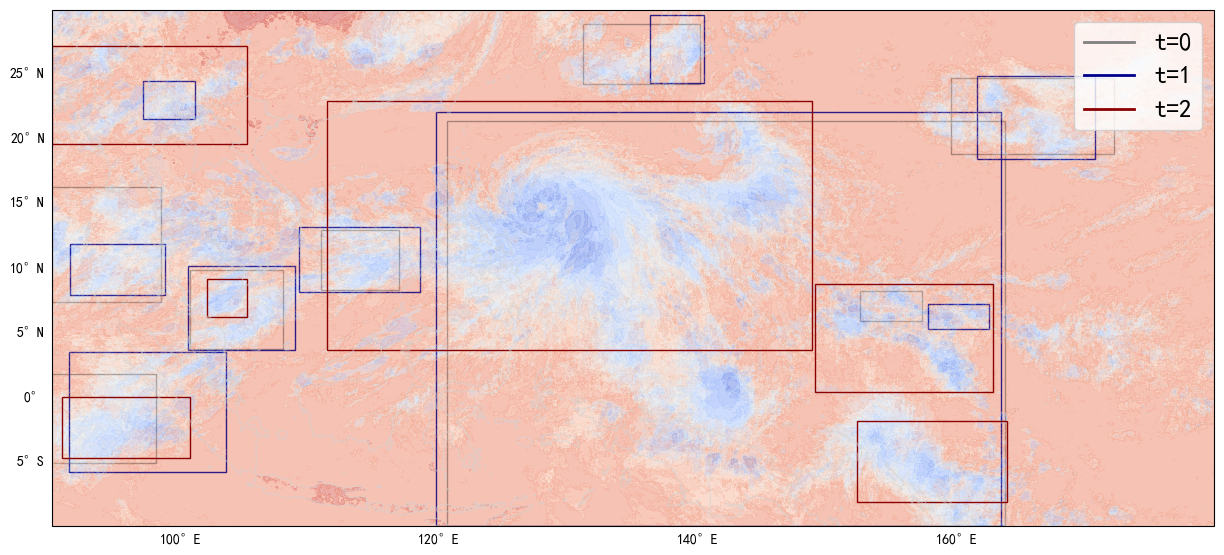

In [23]:

fig, ax = plt.subplots(figsize=(15, 30), subplot_kw={'projection': ccrs.PlateCarree()})
grid = ax.gridlines(draw_labels=True,linewidth=0 )
grid.top_labels = False
grid.right_labels = False
ax.add_feature(cfeature.BORDERS, edgecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='lightgray', alpha=0.5)
# 添加范围
# ax.set_extent([90, 165, -10, 20], crs=ccrs.PlateCarree())

cmap_list = ["binary", 'Blues', 'Reds']    # 数据用了3个时刻， 所以就给了3个颜色
color_list = ['gray', 'darkblue', 'darkred']

myindex = 0

# 绘图
for i_t in range(len(tb_data_list)):
    # 画底图
    ax.contourf(lon,lat , tb_data_list[i_t], 
                cmap='coolwarm', 
                alpha =  0.2,
                transform=ccrs.PlateCarree())

    # 画框
    i_points_list = test_lonlat_info_list[i_t]
    for points in i_points_list:
        polygon = Polygon(points, closed=True, 
                          edgecolor=color_list[i_t],
                          facecolor='none', linewidth=1, transform=ccrs.PlateCarree())
        ax.add_patch(polygon)

# # 添加图例
legend_elements = [
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='t=0'),
    Line2D([0], [0], color='darkblue', lw=2, linestyle='-', label='t=1'),
    Line2D([0], [0], color='darkred', lw=2, linestyle='-', label='t=2'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=18)   
# plt.savefig(savepth, bbox_inches='tight', dpi=dpi, pad_inches=0.1,  )
plt.show()
